In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install mediapipe

In [ ]:
import os
import cv2
import mediapipe as mp
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import numpy as np
import torchvision
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path_to_dataset = '/content/drive/MyDrive/Video_Dataset'

In [ ]:
dataset_dir = os.path.join(path_to_dataset, '')

In [ ]:
!ls dataset_dir

ls: cannot access 'dataset_dir': No such file or directory


In [ ]:
!pip install gradio

In [ ]:
import gradio as gr

##Pipeline for vanilla freqnet

In [ ]:
from freqnet import freqnet

In [ ]:
model = freqnet(num_classes = 2)
model = model.cuda()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
checkpt_path = "/content/drive/MyDrive/Major_Project/checkpoints/CorrectedBeta/freqnet_epoch_9.pth"
cpoint = torch.load(checkpt_path)
#cpoint.keys()
model.load_state_dict(cpoint)
#model.load_state_dict(cpoint['model_state_dict'])
model.eval()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Assuming the model accepts 224x224 images
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])


###Gradio Interface

In [ ]:
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")

    # Preprocess the image
    image = transform(image).unsqueeze(0).cuda()  # Add batch dimension

    # Perform the prediction
    with torch.no_grad():
        output = model(image)

    # Get the predicted class (assuming binary classification)
    pred = torch.sigmoid(output).item()
    print(pred)

    # Threshold to determine if it's a deepfake or not (adjust threshold as needed)
    if pred > 0.5:
        return "Not a Deepfake"
    else:
        return "Deepfake"

In [ ]:
print(classify_image('fakeforreal.png'))

0.41656509041786194
Deepfake


In [ ]:
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),  # Accepts an image input as a PIL object
    outputs="text",  # Output is text ("Deepfake" or "Not a Deepfake")
    title="Deepfake Detector",
    description="Upload an image to determine if it's a deepfake."
)

# Launch the interface
interface.launch()

In [ ]:
def classify_video(video):
  path_to_video = video.name
  result = process_single_video(path_to_video, model, frame_sample_rate = 15)
  return result

In [ ]:
video_interface = gr.Interface(
    fn = classify_video,
    inputs = gr.Video(),
    outputs = "text",
    title = "Deepfake Video Detector",
    description = "Upload a video to determine if it's a deepfake."
)

video_interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0fb0d1f5c614360cac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


###Video Deepfake Detection Pipeline

In [ ]:
#Initializing mediapipe face detection

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1,
                                                 min_detection_confidence=0.5)


In [ ]:
def make_frames(video_path, frame_sample_rate=10, box_scaling=2):
  vid = cv2.VideoCapture(video_path)
  #opencv , imread, VideoCapture, the image frames are loaded in the BGR color space

  total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_indices = np.linspace(0, total_frames-1, frame_sample_rate, dtype=int)

  face_frames = []

  for frame_index in frame_indices:
    vid.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = vid.read()

    if not ret:
      continue

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #Detect the face from the frames using the mediapipe function

    faces = face_detection.process(rgb_frame)

    if faces.detections:
      for detection in faces.detections:
        bounding_box = detection.location_data.relative_bounding_box
        im_height, im_width, im_channel = frame.shape

        x, y, w, h = (int(bounding_box.xmin * im_width),
                      int(bounding_box.ymin * im_height),
                      int(bounding_box.width * im_width),
                      int(bounding_box.height * im_height))

        cx, cy = x + w // 2, y + h // 2  # Center of the box
        w, h = w * box_scaling, h * box_scaling  # Scale width and height
        x, y = cx - w / 2, cy - h / 2  # Adjust coordinates

        #ensuring that the box stays within the frame
        x, y = max(0, int(x)), max(0, int(y))
        w, h = min(int(w), im_width - x), min(int(h), im_height - y)

        face = rgb_frame[y:y+h, x:x+w]
        face_frames.append(face)

  vid.release()
  return face_frames

In [ ]:
def visualize_face_frames(face_frames, num_rows=2, num_columns=5):
  num_frames = len(face_frames)
  plt.figure(figsize=(15, 5))
  for i in range(min(num_frames, num_rows * num_columns)):
    plt.subplot(num_rows, num_columns, i + 1)
    # plt.imshow(cv2.cvtColor(face_frames[i], cv2.COLOR_RGB2BGR))
    plt.imshow(face_frames[i])
    plt.axis('off')
    plt.title(f"Face : {i+1}")
  plt.tight_layout()
  plt.show()

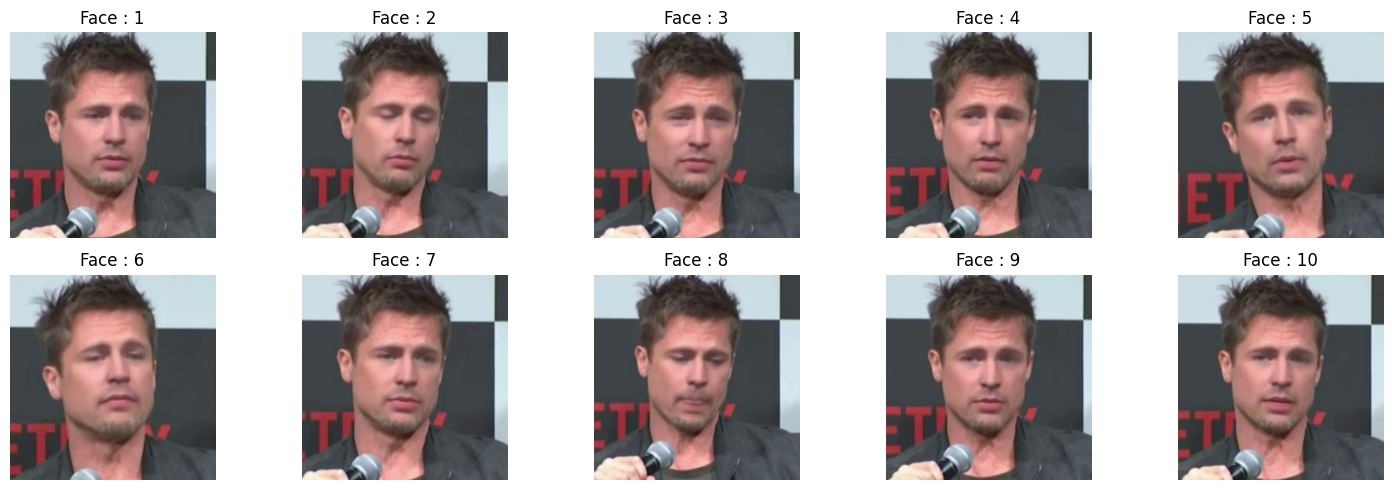

In [ ]:
path_to_video = "/content/id1_id4_0002.mp4"
extracted_face_frames = make_frames(path_to_video, frame_sample_rate = 10)
visualize_face_frames(extracted_face_frames)

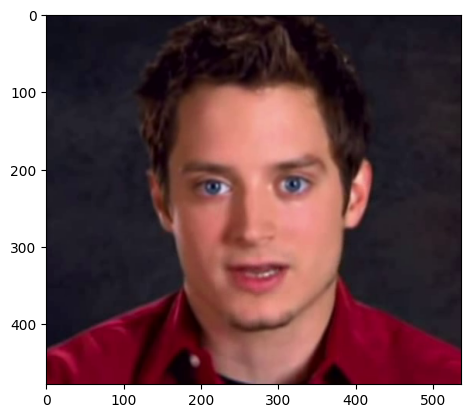

In [ ]:
plt.imshow(extracted_face_frames[6])

In [ ]:
def classify_frames(face_frames, DLmodel, transformation_definition=transform):
  if not face_frames:
    return "Not able to detect any faces"

  logits = []

  for face in face_frames:
    face = Image.fromarray(face)
    face_tensor = transformation_definition(face).unsqueeze(0).cuda()

    with torch.no_grad():
      logit = DLmodel(face_tensor)
      logits.append(logit)

  probabilities = [torch.sigmoid(logit) for logit in logits]
  print(probabilities)

  real_count, fake_count = 0, 0
  for prob in probabilities:
    if prob > 0.5:
      real_count += 1
    else:
      fake_count += 1

  print(f"Real Count: {real_count}\nFake Count: {fake_count}")

  if real_count != fake_count:
    if real_count > fake_count:
      return "real"
    else:
      return "fake"
  else:
    average_probability = torch.stack(probabilities).mean().item()
    print(average_probability)
    if average_probability > 0.5:
        return "real"
    else:
        return "fake"

In [ ]:
def process_single_video(video_path, model, frame_sample_rate = 10, transformation_definition = transform):
  face_frames = make_frames(video_path, frame_sample_rate)
  result = classify_frames(face_frames, model, transform)
  return result

In [ ]:
path_to_video = "/content/id4_id2_0004.mp4"

In [ ]:
print(process_single_video(path_to_video, model))

[tensor([[0.9809]], device='cuda:0'), tensor([[0.8054]], device='cuda:0'), tensor([[0.9998]], device='cuda:0'), tensor([[0.4254]], device='cuda:0'), tensor([[0.8462]], device='cuda:0'), tensor([[0.3016]], device='cuda:0'), tensor([[0.9207]], device='cuda:0'), tensor([[0.9889]], device='cuda:0'), tensor([[0.5718]], device='cuda:0'), tensor([[0.6679]], device='cuda:0')]
Real Count: 8
Fake Count: 2
real


Real are labelled as 1, so output of sigmoid nearer to 1 are real

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_video_directory(video_dir, labels_file, frame_sample_rate=10, box_scaling=2, num_videos_to_evaluate=None):

  with open(labels_file, 'r') as f:
    labels = {line.split(',')[0]: line.strip().split(',')[1] for line in f}

  video_files = [vid for vid in os.listdir(video_dir) if os.path.isfile(os.path.join(video_dir, vid))]

  if num_videos_to_evaluate is None or num_videos_to_evaluate > len(video_files):
    num_videos_to_evaluate = len(video_files)

  selected_videos = random.sample(video_files, num_videos_to_evaluate)

  predictions = []
  ground_truth = []

  for vid in selected_videos:
    video_path = os.path.join(video_dir, vid)

    if not os.path.isfile(video_path):
      continue

    prediction = process_single_video(video_path, model, frame_sample_rate, box_scaling)

    if vid in labels:
      ground_truth.append(labels[vid])
      predictions.append(prediction)

  accuracy = accuracy_score(ground_truth, predictions)
  return accuracy, ground_truth, predictions

In [ ]:
acc, y_true, y_pred = evaluate_video_directory(dataset_dir, 'labels.csv', frame_sample_rate = 15, num_videos_to_evaluate=100)

In [ ]:
print(f"Accuracy of the deepfake detection method: {acc:.2f}")

Accuracy of the deepfake detection method: 0.68


In [ ]:
confusion_mat = confusion_matrix(y_true, y_pred)

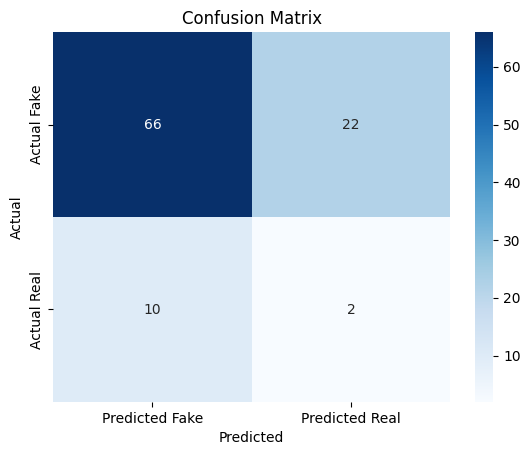

In [ ]:
#Visualising using a heatmap for better visualization

sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Video Pipeline with the CLIP integrated hybrid model

In [ ]:
from HybridClass import HybridDeepfakeDetector
from clipped_freqnet import freqnet

In [ ]:
#Initialize the models
freqnet_model = freqnet(num_classes=2)
h_model = HybridDeepfakeDetector(freqnet_model, device=device).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
path_to_saved_model = "/content/drive/MyDrive/Major_Project_Models/checkpoint_epoch_8.pth"

In [ ]:
print(loaded_model.state_dict())

NameError: name 'loaded_model' is not defined

In [ ]:
loaded_model, _, _ = HybridDeepfakeDetector.load_entire_model(path_to_saved_model, freqnet_model,
                                                              device=device)

/content/HybridClass.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model loaded from /content/drive/MyDrive/Major_Project_Models/checkpoint_epoch_8.pth, last trained epoch: 9


In [ ]:
#make some inferences to check the sanity of the loaded model in test samples
#from a different data distribution

def infer(image_path, model, device = device):
  Image.load_truncated_image = True
  image = Image.open(image_path)
  display(image)
  model.eval()

  with torch.no_grad():
      tensor_image = imagenet_transform(image).unsqueeze(0).to(device)
      #gotta add the batch dimension because model uses it like that
      output_logit = model(tensor_image, tensor_image)
      probability = torch.sigmoid(output_logit).item()
      print(probability)
      if probability > 0.5:
          return "This image is a REAL image"
      else:
          return "This image is a FAKE image"

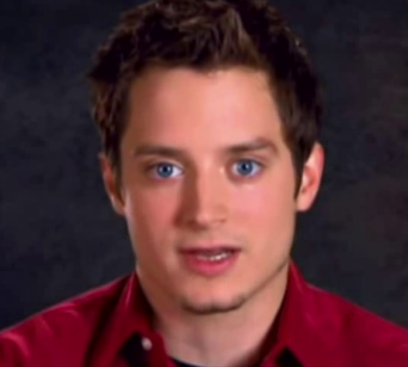

0.5073055624961853
This image is a REAL image


In [ ]:
print(infer("videoframe.png", loaded_model, device))

This shows that the loaded model is performing really well

In [ ]:
imagenet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:3, :, :] if x.shape[0] == 4 else x),  # Select RGB channels only
    #Typically screenshots are saved with alpha parameter, this has not been accounted for
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
#Initializing mediapipe face detection

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1,
                                                 min_detection_confidence=0.5)


In [ ]:
def make_frames(video_path, frame_sample_rate=10, box_scaling=2):
  vid = cv2.VideoCapture(video_path)
  #opencv , imread, VideoCapture, the image frames are loaded in the BGR color space

  total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_indices = np.linspace(0, total_frames-1, frame_sample_rate, dtype=int)

  face_frames = []

  for frame_index in frame_indices:
    vid.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    ret, frame = vid.read()

    if not ret:
      continue

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    #Detect the face from the frames using the mediapipe function

    faces = face_detection.process(rgb_frame)

    if faces.detections:
      for detection in faces.detections:
        bounding_box = detection.location_data.relative_bounding_box
        im_height, im_width, im_channel = frame.shape

        x, y, w, h = (int(bounding_box.xmin * im_width),
                      int(bounding_box.ymin * im_height),
                      int(bounding_box.width * im_width),
                      int(bounding_box.height * im_height))

        cx, cy = x + w // 2, y + h // 2  # Center of the box
        w, h = w * box_scaling, h * box_scaling  # Scale width and height
        x, y = cx - w / 2, cy - h / 2  # Adjust coordinates

        #ensuring that the box stays within the frame
        x, y = max(0, int(x)), max(0, int(y))
        w, h = min(int(w), im_width - x), min(int(h), im_height - y)

        face = rgb_frame[y:y+h, x:x+w]
        face_frames.append(face)

  vid.release()
  return face_frames

In [ ]:
def classify_frames_with_CLIP(face_frames, model, device, freq_transform=imagenet_transform):

    if not face_frames:
        return "Not able to detect any faces"

    model.eval()  # Set model to evaluation mode
    probabilities = []

    with torch.no_grad():
        for face in face_frames:
            # Convert image to tensor
            face_image = Image.fromarray(face)
            freq_input = freq_transform(face_image).unsqueeze(0).to(device)  # For FreqNet
            clip_input = freq_input.clone()  # Use the same normalized image for CLIP (denormalized inside the model)

            # Forward pass through HybridDeepfakeDetector
            logit = model(freq_input, clip_input)
            probability = torch.sigmoid(logit).item()
            probabilities.append(probability)

    # Calculate average probability across frames
    print(probabilities)
    average_probability = np.mean(probabilities)
    print(f"\nMean Prob: {average_probability}")
    return "real" if average_probability > 0.507 else "fake"


In [ ]:
def process_single_video_with_CLIP(video_path, model, device, frame_sample_rate=10):
    face_frames = make_frames(video_path, frame_sample_rate=frame_sample_rate)
    result = classify_frames_with_CLIP(face_frames, model, device)
    return result

In [ ]:
video_path = "/content/id0_id2_0003.mp4"

In [ ]:
result = process_single_video_with_CLIP(video_path, loaded_model, device)
print("Prediction:", result)

[0.5087335109710693, 0.5086434483528137, 0.5086390376091003, 0.5086539387702942, 0.508524477481842, 0.5086728930473328, 0.5085672736167908, 0.5086506605148315, 0.5087615251541138, 0.5094924569129944]

Mean Prob: 0.5087339222431183
Prediction: real


###Test Accuracy for videos

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_video_directory_with_hybridmodel(video_dir, labels_file, frame_sample_rate=10, box_scaling=2, num_videos_to_evaluate=None):

  with open(labels_file, 'r') as f:
    labels = {line.split(',')[0]: line.strip().split(',')[1] for line in f}

  video_files = [vid for vid in os.listdir(video_dir) if os.path.isfile(os.path.join(video_dir, vid))]

  if num_videos_to_evaluate is None or num_videos_to_evaluate > len(video_files):
    num_videos_to_evaluate = len(video_files)

  selected_videos = random.sample(video_files, num_videos_to_evaluate)

  predictions = []
  ground_truth = []

  for vid in selected_videos:
    video_path = os.path.join(video_dir, vid)

    if not os.path.isfile(video_path):
      continue

    prediction = process_single_video_with_CLIP(video_path, loaded_model, frame_sample_rate, box_scaling)

    if vid in labels:
      ground_truth.append(labels[vid])
      predictions.append(prediction)

  accuracy = accuracy_score(ground_truth, predictions)
  return accuracy, ground_truth, predictions

In [ ]:
acc, y_true, y_pred = evaluate_video_directory_with_hybridmodel(dataset_dir, 'labels.csv', frame_sample_rate = 15, num_videos_to_evaluate=100)

In [ ]:
print(f"Accuracy of the deepfake detection method: {acc:.2f}")

In [ ]:
confusion_mat = confusion_matrix(y_true, y_pred)

In [ ]:
#Visualising using a heatmap for better visualization

sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Fake', 'Predicted Real'],
            yticklabels=['Actual Fake', 'Actual Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()